In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Задача 1
# Информация Фишера и неравенство Крамера-Рао

Информацию Фишера можно использовать для расчёта ошибок в оценке параметров и корреляций ошибок.

Это делается из [неравенства Крамера-Рао](https://ru.wikipedia.org/wiki/%D0%9D%D0%B5%D1%80%D0%B0%D0%B2%D0%B5%D0%BD%D1%81%D1%82%D0%B2%D0%BE_%D0%9A%D1%80%D0%B0%D0%BC%D0%B5%D1%80%D0%B0_%E2%80%94_%D0%A0%D0%B0%D0%BE), которое утверждает, что снизу дисперсия параметра ограничена диагональным членом матрицы обратной к матрице Фишера.

### Постановка задачи

#### Условие

Пусть у нас есть некоторый сигнал:

$$a(t) = A \sin(2 \pi f t + \phi)$$


При передаче сигнала он зашумляется. Предположим, что нам известна форма и параметры шума: $\mathcal{N}(0, \sigma^2)$. Тогда мы будем наблюдать следующий сигнал в момент времени $t_i$:

$$\hat{a}_i \sim A \sin(2 \pi f t_i + \phi) + \mathcal{N}(0, \sigma^2) = \mathcal{N}\left(A \sin(2 \pi f t_i + \phi), \sigma^2 \right)$$


#### Задача

По набору измерений: $\{t_i\}_{i=1}^{N}$ и $\{\hat{a}_i\}_{i=1}^{N}$ мы хотим:
  * восстановить параметры изначального сигнала $A,~f,~\phi$;
  * оценить ошибки восстановления параметров;
  * оценить корреляции параметров;
  * оценить "важность" какждого измерения для оценки каждого из параметров.

In [2]:
from scipy.misc import derivative
from scipy.optimize import curve_fit
import inspect
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(font_scale=3)

Text(0.5,0,'time (s)')

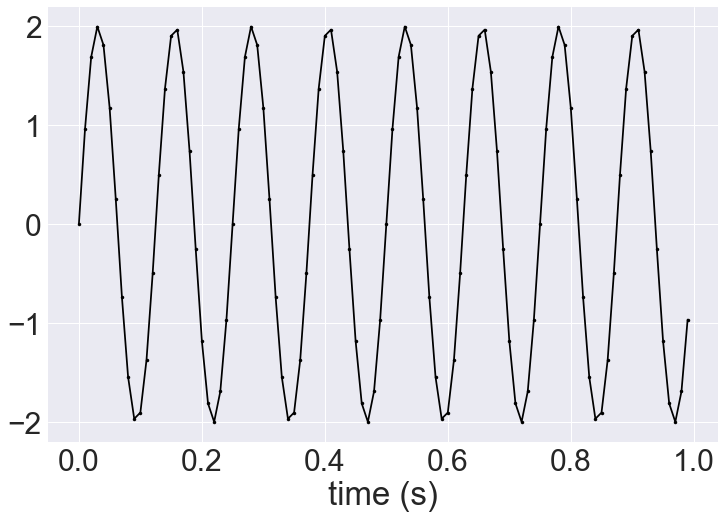

In [3]:
def signal(t, a, f, ph):
    """
    Функция генерации сигнала
    """
    return a * np.sin(2 * np.pi * f * t + ph)

# параметры сигнала
parameters = {
    'a': 2,
    'f': 8,
    'ph': 0
}

# уровень шума
noise = 0.1

# диапазон измерения
T = np.arange(0, 1, 0.01)

plt.figure(figsize=(12, 8))
plt.plot(T, signal(T, **parameters), '.-k')
plt.xlabel('time (s)')

### Вывод формул

Введём формальную терминологию.

Вектор параметров:

$$\theta = [A, f, \phi]$$

Вероятностная модель:

$$\hat{a}_i(\theta) \sim \mathcal{N}\left(A \sin(2 \pi f t_i + \phi), \sigma^2 \right)$$

$$\log p(\hat{a}_i) = - \frac{1}{2\sigma^2} \left( \hat{a}_i - A \sin(2 \pi f t_i + \phi)  \right)^2 - \log 2 \pi - \frac{1}{2} \log \sigma$$

Матрица Фишера для одного измерения:

$$\mathcal{I}(\theta) = \mathbb{E} \left( \left(\frac{\partial \log p(\hat{a}_i)}{\partial \theta}\right) \left(\frac{\partial \log p(\hat{a}_i)}{\partial \theta}\right)^T \right) = \mathbb{E} \left( \frac{\partial^2 \log p(\hat{a}_i)}{\partial \theta^2} \right)$$


Найдём же эту вторую производную:

$$\frac{\partial \log p(\hat{a}_i)}{\partial \theta_i} = -\frac{1}{\sigma^2} a'_{\theta_i} \left( a(t_i) - \hat{a}_i \right)$$


$$\frac{\partial^2 \log p(\hat{a}_i)}{\partial \theta_i \partial \theta_j} = -\frac{1}{\sigma^2} a''_{\theta_i,~\theta_j} \left( a(t_i) - \hat{a}_i \right) - \frac{1}{\sigma^2} a'_{\theta_i} a'_{\theta_j}$$ 

$$\mathbb{E} \left( \frac{\partial^2 \log p(\hat{a}_i)}{\partial \theta_i \partial \theta_j} \right) = - \frac{1}{\sigma^2} a'_{\theta_i} a'_{\theta_j}$$


Тогда матрица Фишера выражается следующим образом:

$$\mathcal{I} = \frac{1}{\sigma^2} \sum_i \left( \frac{\partial a(t_i)}{\partial \theta} \right) \left( \frac{\partial a(t_i)}{\partial \theta} \right)^T$$

Переопределим: $D_{mi} := \frac{\partial a(t_i)}{\partial \theta_m}$, тогда:

$$\mathcal{I}_{mn} = \frac{1}{\sigma^2} \sum_i \frac{\partial a(t_i)}{\partial \theta_m} \frac{\partial a(t_i)}{\partial \theta_n} = \frac{1}{\sigma^2} \sum_k D_{mi} D_{ni}$$

In [4]:
{**parameters, **{'a': 5}}

{'a': 5, 'f': 8, 'ph': 0}

In [5]:
D = np.zeros((len(parameters), len(T)))

# для каждого параметра
for i, argname in enumerate(parameters.keys()):
    # для каждого измерения
    for k, t in enumerate(T):
        # определим функцию по которой будем считать производную
        func = lambda x: signal(t, **{**parameters, **{argname: x}})
        
        # посчитаем производную
        D[i,k] = derivative(func, parameters[argname], dx=0.0001)

Посмотрим на зависимость $D$ для разных переменных. 

Заметим ещё раз, что по количество строк в матрице $D$ совпадает с длиной вектора $\theta$, а количество столбцов с количеством измерений.

In [6]:
D.shape

(3, 100)

Text(0.5,0,'time (s)')

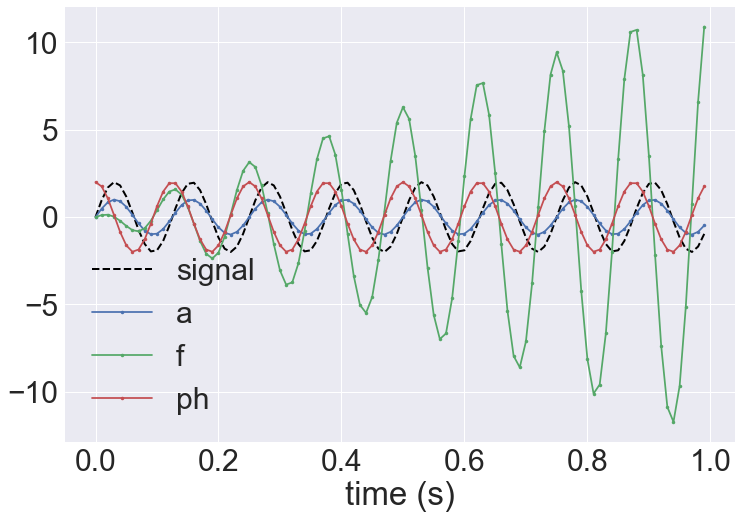

In [7]:
plt.figure(figsize=(12, 8))

plt.plot(T, signal(T, **parameters), '--k', lw=2, label='signal')

for Di, argname in zip(D, parameters.keys()):
    plt.plot(T, Di, '.-', label=argname)
    
plt.legend(loc='best')
plt.xlabel('time (s)')

Матрица $D_{ik}$ показывает как сильно $i$-ый параметр влияет на $k$-ое измерение. К примеру, видно, на параметр амплитуды сильнее всего влияет на значения в пиках синуса. 

Кроме того, последние точки оказываются более чувствительными к частоте. 

А теперь посчитаем матрицу Фишера по матрице $D$:
$$\mathcal{I}_{m,n}= \frac{1}{\sigma^2} \sum_k D_{mk} D_{nk}$$

Посчитаем это с помощью функции из numpy: [```einsum```](http://docs.scipy.org/doc/numpy/reference/generated/numpy.einsum.html)

In [8]:
I = np.einsum('ij,kj', D, D) / noise**2
print(I)

[[ 5.00000000e+03 -5.71453545e+02 -1.55465640e-09]
 [-5.71453545e+02  2.55477009e+05  6.15752139e+04]
 [-1.55465640e-09  6.15752139e+04  1.99999999e+04]]


В ячейчке выше мы посмотрим на дисперсии оценок на параметры сигнала с помощью Крамера-Рао.

In [9]:
I_inv = np.linalg.inv(I)

for argname, variance in zip(parameters.keys(), I_inv.diagonal()):
    print('{}: {:.2g}'.format(argname, np.sqrt(variance)))

a: 0.014
f: 0.0039
ph: 0.014


А здесь мы воспользуемся функцией `curve_fit`, которая делает автоматический фит по конечной выборке и выдаёт оптимальные параметры и ошибки.

Как видно, они достаточно похожи.

Стоит отметить, что некорректно сравнивать ошибки посчитанные с помощью Крамера-Рао и `curve_fit`, так как они имеют достаточно разную природу. 

a: 0.015
f: 0.0038
ph: 0.014


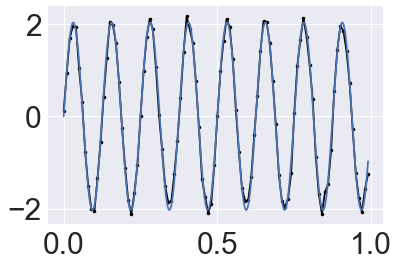

In [10]:
S = signal(T, **parameters) + np.random.randn(T.size) * noise
plt.plot(T, S, '.-k')

popt, pcov = curve_fit(signal, T, S, p0=list(parameters.values()))

for argname, variance in zip(parameters.keys(), pcov.diagonal()):
    print('{}: {:.2g}'.format(argname, np.sqrt(variance)))

Tl = np.linspace(T[0], T[-1], 10000)
plt.plot(Tl, signal(Tl, *popt))

In [11]:
def cramer_rao(model, p0, X, noise, show_plot=False):
    D = np.zeros((len(p0), X.size))
    for i, argname in enumerate(parameters.keys()):
        for k, t in enumerate(T):
            func = lambda x: signal(t, **{**parameters, **{argname: x}})
            D[i,k] = derivative(func, parameters[argname], dx=0.0001)
        
    if show_plot:
        plt.plot(X, model(X, **parameters), '--k', lw=2, label='signal')
        for Di, argname in zip(D, parameters.keys()):
            plt.plot(T, Di, '.-', label=argname)

        plt.legend(loc='best')
        plt.title('Зависимость параметра от ошибки измерения в конкретной точки')
    
    I = np.einsum('mk,nk', D, D) / noise**2
    I_inv = np.linalg.inv(I)
    
    return I_inv

на графике ниже мы показываем как ошибки в определённых точках влияют на оценку параметров $\theta$.

Text(0.5,0,'time (s)')

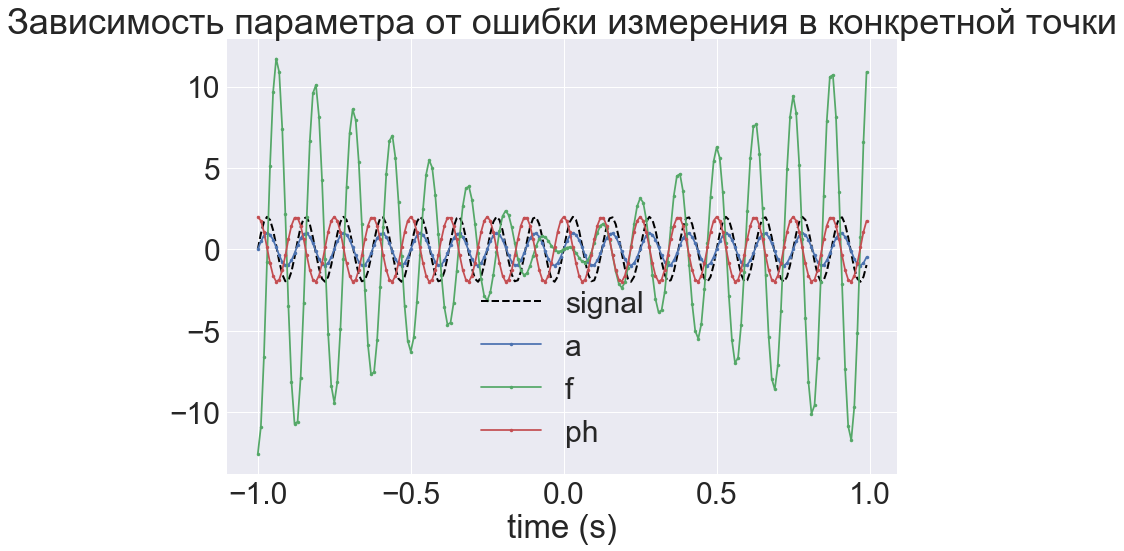

In [12]:
plt.figure(figsize=(12, 8))

T = np.arange(-1., 1, 0.01)
cramer_rao(signal, parameters, T, noise, show_plot=True);
plt.xlabel('time (s)')

# Задача 2 

# Дельта-метод

Расмотрим следующую функцию: 

$$g(x) = \frac{\exp(x)}{1 + \exp(x)} = \sigma(x)$$

Эта функция часто используется в машинном обучении, физике, химии и имеет специальное название: __логистическая функция__. 

Её производная:

$$\sigma'(x) = \sigma(x)(1 - \sigma(x))$$

Оригинальная выборка сэмплируется из нормального распределения:

$$x \sim \mathcal{N}(\mu, \sigma^2)$$

Тогда дельта-метод утверждает следующее:

$$g(x) \sim \mathcal{N}(g(\mu), \sigma^2 g'(\mu)^2 )$$

In [13]:
from scipy.stats import norm
from scipy.special import expit

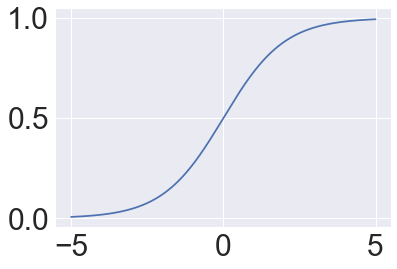

In [14]:
x = np.linspace(-5, 5, 1000)
plt.plot(x, expit(x))

### Предварительный анализ задачи


Сгенерируем выборки из нормального распределения с разными $\mu$ и $\sigma^2$ и посмотрим как они трансформируются при применении $g(\cdot)$.

#### Вопрос: какая максимальная возможная дисперсия $Var(g(x))$?

In [15]:
mus = np.linspace(-1.5, 1.5, 3)
sigmas = np.linspace(1e-1, 10, 3)

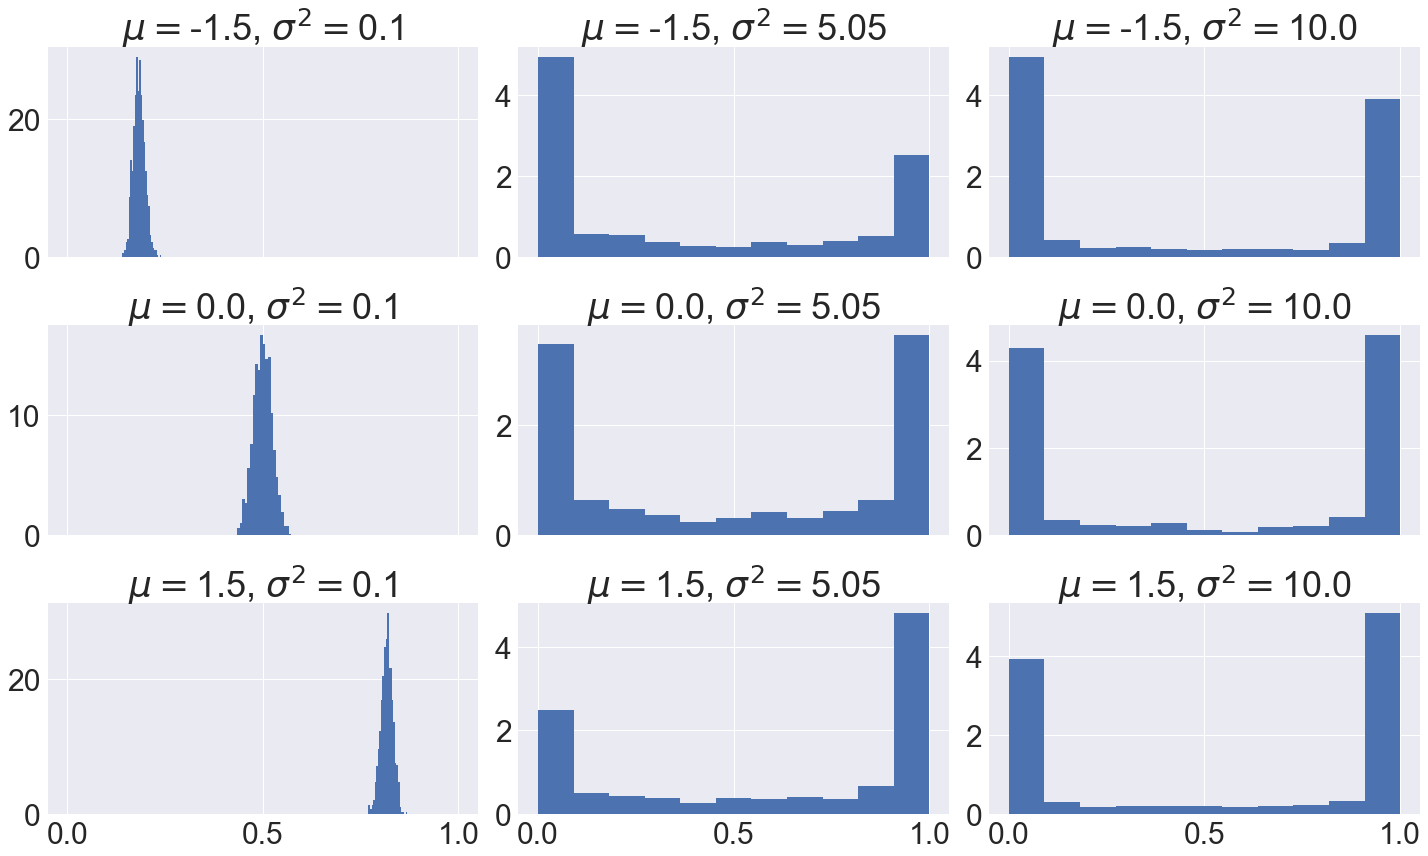

In [16]:
fig, ax = plt.subplots(len(mus), len(sigmas), sharex=True, sharey=False, figsize=(20, 12))

for i, mu in enumerate(mus):
    for j, sigma in enumerate(sigmas):
        ax[i][j].hist(expit(norm.rvs(size=1000, loc=mu, scale=sigma)), bins='auto', density=True)
        ax[i][j].set_title('$\mu=${}, $\sigma^2=${}'.format(mu, sigma))
        
plt.tight_layout()
plt.show()

In [17]:
def get_mean_var_delta(mu, sigma):
    mean = expit(mu)
    var = (expit(mu) * (1 - expit(mu)))**2  * (sigma) ** 2
    return mean, var

def get_mean_var_true(mu, sigma, N=int(1e4)):
    x = np.linspace(mu - 5 * sigma, mu + 5 * sigma, N)
    pdf = norm.pdf(x, loc=mu, scale=sigma)
    Z = pdf.sum()
    expit_x = expit(x)
    
    mean = (expit_x * pdf).sum() / Z
    var = (((expit_x - mean)**2) * pdf).sum() / Z
    return mean, var

#### Для набора средних посмотрим на зависимость от дисперсии

In [18]:
mus = np.linspace(-1.5, 1.5, 7)
sigmas = np.linspace(1e-2, 10, 1000)

In [19]:
mean_delta = []
var_delta = []

mean_true = []
var_true = []

for mu in mus:
    means, vars = list(zip(*[get_mean_var_delta(mu, sigma) for sigma in sigmas]))
    mean_delta.append(means)
    var_delta.append(vars)
    
    means, vars = list(zip(*[get_mean_var_true(mu, sigma) for sigma in sigmas]))
    mean_true.append(means)
    var_true.append(vars)

In [ ]:
fig, ax = plt.subplots(len(mus), 1, sharex=True, figsize=(15, 30))

for i in range(len(mus)):
    ax[i].plot(sigmas, mean_delta[i], label='Mean delta')
    ax[i].plot(sigmas, mean_true[i], label='Mean true')
    ax[i].set_title('$\mu$={}'.format(mus[i]))
    ax[i].legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(len(mus), 1, sharex=True, figsize=(15, 30))

for i in range(len(mus)):
    ax[i].plot(sigmas, var_delta[i], label='$\sigma^2$ delta')
    ax[i].plot(sigmas, var_true[i], label='$\sigma^2$ true')
    ax[i].set_title('$\mu$={}'.format(mus[i]))
    ax[i].legend(loc='best')
    ax[i].set_xlabel('$\sigma$')

plt.tight_layout()
plt.show()

#### Для набора дисперсий посмотрим на зависимость от средних

In [ ]:
mus = np.linspace(-1.5, 1.5, 1000)
sigmas = np.linspace(1e-2, 10, 5)

In [ ]:
mean_delta = []
var_delta = []

mean_true = []
var_true = []

for sigma in sigmas:
    means, vars = list(zip(*[get_mean_var_delta(mu, sigma) for mu in mus]))
    mean_delta.append(means)
    var_delta.append(vars)
    
    means, vars = list(zip(*[get_mean_var_true(mu, sigma) for mu in mus]))
    mean_true.append(means)
    var_true.append(vars)

In [ ]:
fig, ax = plt.subplots(len(sigmas), 1, sharex=True, figsize=(15, 30))

for i in range(len(sigmas)):
    ax[i].plot(mus, mean_delta[i], label='Mean delta')
    ax[i].plot(mus, mean_true[i], label='Mean true')
    ax[i].set_title('$\sigma$={}'.format(sigmas[i]))
    ax[i].legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(len(sigmas), 1, sharex=True, figsize=(15, 30))

for i in range(len(sigmas)):
    ax[i].plot(mus, var_delta[i], label='Var delta')
    ax[i].plot(mus, var_true[i], label='Var true')
    ax[i].set_title('$\sigma$={}'.format(sigmas[i]))
    ax[i].legend(loc='best')

plt.tight_layout()
plt.show()

### Главный вывод: не пользуйтесь дельта-методом, если не уверены что задача линеаризуется хорошо.

# Задача 3
# Гистограмная оценка плотности

In [ ]:
import scipy
import scipy.stats
from scipy import stats
from sklearn.neighbors.kde import KernelDensity
from sklearn.model_selection import KFold, train_test_split

 Для выбора оптимальной ширины бина нужно найти минимум следующего функционала(эмпирического риска):

\begin{gather*}
J(h) = \int \hat{p}^2(x) dx - 2 \int \hat{p}(x) p(x) dx
\end{gather*}

Эквивалентная изначальной формуле, но более удобная для вычисления:

\begin{gather*}
\hat{J}(h) = \frac{2}{(n - 1)h} - \frac{n+1}{(n-1)h}\sum_{i = 1}^m \hat{p}_j^2,\quad \hat{p}_j = \frac{n_j}{n}.
\end{gather*}

### Выбор оптимальной ширины бинов

In [ ]:
seed = 1
n_samples = 100
gen1 = scipy.stats.norm(loc=0, scale=1)
gen2 = scipy.stats.norm(loc=5, scale=1)
p1 = 0.3
p2 = 1 - p1
samples1 = gen1.rvs(size=int(p1 * n_samples), random_state=seed)       # Samples from the first components
samples2 = gen2.rvs(size=int(p2 * n_samples), random_state=seed + 1)   # Samples from the second components
samples = np.concatenate([samples1, samples2])                         # All samples

x_values = np.linspace(-5, 10, 1000)
binedges = np.linspace(-5, 10, 10)
true_pdf = p1 * gen1.pdf(x_values) + p2 * gen2.pdf(x_values)

In [ ]:
def create_binedges(center, bandwidth, x_left, x_right):
    """
    Функция для создания массива краёв бинов. 
    На вход приходит центр, ширина бина, левый край и правый край.
    """
    h = bandwidth
    bins = [center - h / 2]
    while x_left < bins[-1]:
        bins.append(bins[-1] - h)
    bins = list(reversed(bins))
    while x_right > bins[-1]:
        bins.append(bins[-1] + h)
    # <YOUR CODE>
    return bins

In [ ]:
def histogram_pdf_estimated_risk(bincounts, h):
    """
    Функция оценки эмпирического 
    """
    n = np.sum(bincounts)
    ps = bincounts / n
    J = 2 / ((n - 1) * h) - ((n + 1.0) / (h * (n - 1.0))) * np.sum(ps ** 2) # <YOUR CODE>
    return J

In [ ]:
bandwidth_range = np.linspace(0.01, 10, 1000)
risk_values = []
for bandwidth in bandwidth_range:
    binedges = create_binedges(0, bandwidth, samples.min(), samples.max())
    bincounts, _ = np.histogram(samples, bins=binedges)
    risk_values.append(histogram_pdf_estimated_risk(bincounts, bandwidth))
risk_values = np.array(risk_values)

plt.figure(figsize=(10, 8))
plt.plot(bandwidth_range, risk_values, color='b', label=r'$\hat{J}(h)$', zorder=2);
plt.legend();
plt.grid(which='both', linestyle='--', alpha=0.5);

In [ ]:
index_min = np.argmin(risk_values)
opt_bandwidth = bandwidth_range[index_min]
min_risk = risk_values[index_min]
print('h = {}, J = {}'.format(opt_bandwidth, min_risk))

### PDF для оптимальной ширины ядра

In [ ]:
binedges = create_binedges(0, opt_bandwidth, samples.min(), samples.max())
plt.figure(figsize=(10, 8))
plt.hist(samples, bins=binedges, color='b', density=True, edgecolor='k', 
         label='estimated pdf', alpha=0.5, zorder=2);
plt.plot(x_values, true_pdf, color='r', label='true pdf', zorder=2);
plt.legend();
plt.grid(which='both', linestyle='--', alpha=0.5);

# Задача 4
# Ядерная оценка плотности

\begin{gather*}
MISE = \frac{1}{4} \sigma_K^4 h^4 \int (p''(x))^2 dx + \frac{1}{nh} \int \left( K(x) \right)^2 dx
\end{gather*}

**Что оказывает наибольшее влияние на качество оценки ядерной плотностью?**

При вычислениях пользуемся оценкой эмпирического риска вида:
\begin{gather*}
\hat{J}(h) = \frac{1}{hn^2}\sum_{i = 1}^n \sum_{j = 1}^n K^{(2)}\left(\frac{x_i - x_j}{h}\right) + \frac{K(0)}{nh},
\end{gather*}
где
\begin{gather*}
K^{(2)}(x) = K^*(x) - 2K(x), \quad K^*(x) = \int K(x - y) K(y) dy.
\end{gather*}

Подробности о формуле выше: http://www.stat.cmu.edu/~larry/=sml/densityestimation.pdf

Далее приводятся примеры [ядерное оценивание плотности из библиотеки sklearn](http://scikit-learn.org/stable/modules/density.html)

In [ ]:
def gaussian_kernel_estimated_risk(samples, bandwidth):
    """
    Arguments:
    -samples: 1D numpy array with samples
    -bandwidth: bandwidth parameter of gaussian kernel
    
    Returns estimated risk value.
    """
    X = samples
    h = bandwidth
    n = len(X)
    Jh = 0
    Xi = X[None, :]
    Xj = X[:, None]
    points = (Xi - Xj) / h

    Jh = np.sum(stats.norm.pdf(points, loc=0, scale=np.sqrt(2))) - 2 * np.sum(stats.norm.pdf(points, loc=0, scale=1))
    Jh /= h * (n**2)
    Jh += (2.0 / (h * n)) * stats.norm.pdf(0, loc=0, scale=1) # <YOUR CODE>
    return Jh

In [ ]:
from itertools import product

seed = 1
n_samples = 100
gen1 = scipy.stats.norm(loc=0, scale=1)
gen2 = scipy.stats.norm(loc=5, scale=1)
p1 = 0.3
p2 = 1 - p1
samples1 = gen1.rvs(size=int(p1 * n_samples), random_state=seed)       # Samples from the first components
samples2 = gen2.rvs(size=int(p2 * n_samples), random_state=seed + 1)   # Samples from the second components
samples = np.concatenate([samples1, samples2])                         # All samples

alpha = 0.01; gamma = 0.25
x_left = np.percentile(samples, 100 * alpha)
x_right = np.percentile(samples, 100 * (1 - alpha))
x_width = x_right - x_left
x_left  -= gamma * x_width
x_right += gamma * x_width
print(x_left, x_right, x_width)

x_values = np.linspace(-5, 10, 1000)
binedges = np.linspace(-5, 10, 10)
true_pdf = p1 * gen1.pdf(x_values) + p2 * gen2.pdf(x_values)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 12))

# histogram 1
ax[0, 0].hist(samples, bins=binedges, fc='#AAAAFF', density=True, edgecolor='k')
ax[0, 0].set_title("Histogram")

# histogram 2
ax[0, 1].hist(samples, bins=binedges + 0.75, fc='#AAAAFF', density=True, edgecolor='k')
ax[0, 1].set_title("Histogram, bins shifted")

# tophat KDE
kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(samples[:,None]) #<YOUR CODE>
log_dens = kde.score_samples(x_values[:,None]) #<YOUR CODE>
ax[1, 0].plot(x_values, np.exp(log_dens), color='k', zorder=2)
ax[1, 0].fill(x_values, np.exp(log_dens), fc='#AAAAFF', zorder=2)
ax[1, 0].set_title("Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(samples[:,None]) #<YOUR CODE>
log_dens = kde.score_samples(x_values[:,None]) #<YOUR CODE>
ax[1, 1].plot(x_values, np.exp(log_dens), color='k', zorder=2)
ax[1, 1].fill(x_values, np.exp(log_dens), fc='#AAAAFF')
ax[1, 1].set_title("Gaussian Kernel Density")

for n_row, n_col in product(range(2), range(2)):
    ax[n_row, n_col].grid(which='both', linestyle='--', alpha=0.5)
    ax[n_row, n_col].plot(x_values, true_pdf, color='r', linestyle='--', zorder=2);
    
for axi in ax.ravel():
    axi.plot(samples, np.zeros(len(samples)) - 0.01, '+k')
    axi.set_xlim(x_left, x_right)
    axi.set_ylim(-0.02, 0.34)

for axi in ax[:, 0]:
    axi.set_ylabel('Normalized Density')

for axi in ax[1, :]:
    axi.set_xlabel('$x$')
    
fig.tight_layout()

## Выбор оптимальной ширины ядра

In [ ]:
seed = 1
n_samples = 100
gen1 = scipy.stats.norm(loc=0, scale=1)
gen2 = scipy.stats.norm(loc=5, scale=1)
p1 = 0.3
p2 = 1 - p1
samples1 = gen1.rvs(size=int(p1 * n_samples), random_state=seed)       # Samples from the first components
samples2 = gen2.rvs(size=int(p2 * n_samples), random_state=seed + 1)   # Samples from the second components
samples = np.concatenate([samples1, samples2])                         # All samples

x_values = np.linspace(-5, 10, 1000)
binedges = np.linspace(-5, 10, 10)
true_pdf = p1 * gen1.pdf(x_values) + p2 * gen2.pdf(x_values)

In [ ]:
bandwidth_range = np.linspace(0.01, 10, 1000)
risk_values = []
for bandwidth in bandwidth_range:
    risk_values.append(gaussian_kernel_estimated_risk(samples, bandwidth))
risk_values = np.array(risk_values)

plt.figure(figsize=(10, 8))
plt.plot(bandwidth_range, risk_values, color='b', label=r'$\hat{J}(h)$', zorder=2);
plt.legend();
plt.grid(which='both', linestyle='--', alpha=0.5);

In [ ]:
index_min = np.argmin(risk_values)
opt_bandwidth = bandwidth_range[index_min]
min_risk = risk_values[index_min]
print('h = {}, J = {}'.format(opt_bandwidth, min_risk))

In [ ]:
kde = KernelDensity(bandwidth=opt_bandwidth)
kde.fit(samples[:,None])
pdf = np.exp(kde.score_samples(x_values[:,None]))

plt.figure(figsize=(10, 8))
plt.plot(x_values, pdf, color='b', label='estimated pdf', zorder=2);
plt.plot(x_values, true_pdf, color='r', label='true pdf', zorder=2);
plt.legend();
plt.grid(which='both', linestyle='--', alpha=0.5);

# Задача 5
# Непараметрическая регрессия

Формула Надарая-Ватсона
\begin{gather*}
a(x;X, Y) = \frac{\sum_{i = 1}^n y_j K\left(\frac{\rho(x, x_j)}{h}\right)}{\sum_{j=1}^n K\left(\frac{\rho(x,x_j)}{h}\right)}
\end{gather*}

Оценка риска 
\begin{gather*}
\hat{J}(h) = \sum_{i = 1}^n (y_i - a(x_i;X_{(i)},Y_{(i)}))^2 = 
\sum_{i = 1}^{n} \left( y_i - \frac{\sum_{j} y_j K_{ij}}{\sum_{j}K_{ij}}\right)^{2} \cdot \left( 1 - \frac{K(0)}{\sum_{j=1}^n K_{ij}} \right)^{-2}.
\end{gather*}

In [ ]:
class GaussianKernel:
    def __init__(self, loc=0, scale=1):
        self.loc = loc
        self.scale = scale
    def __call__(self, x):
        """
        Возвращает плотность распределение в точке x.
        """
        return stats.norm.pdf(x, loc=self.loc, scale=self.scale)

class NadarayaWatsonRegressor:
    def __init__(self, kernel, bandwidth):
        self.kernel = kernel
        self.bandwidth = bandwidth
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
    def predict(self, X):
        K_X = (X[:,None] - self.X[None,:]) / self.bandwidth
        K = self.kernel(K_X)
        predictions = np.sum(K * self.Y[None, :], axis=1) / np.sum(K, axis=1)
        return predictions
    
def nw_regression_estimated_risk(X, Y, bandwidth, kernel=GaussianKernel()):
    h = bandwidth
    nw_regressor = NadarayaWatsonRegressor(GaussianKernel(), h)
    nw_regressor.fit(X, Y)
    Y_pred = nw_regressor.predict(X)
    K_X = (X.reshape((-1, 1)) - X.reshape((1, -1))) / h
    K = kernel(K_X)
    K_sums = np.sum(K, axis=1)
    J = np.sum((((Y - Y_pred) * K_sums) / (K_sums - kernel(0)))**2)
    return J

In [ ]:
rng = np.random.RandomState(0)
X = 15 * rng.rand(100)
Y = np.sin(X).ravel()
Y += 3 * (0.5 - rng.rand(X.shape[0]))

x_values = np.linspace(X.min(), X.max(), num=1000)
y_values = np.sin(x_values)

plt.figure(figsize=(10, 8))
plt.plot(x_values, y_values, color='b', label='$y(x)$')
plt.scatter(X, Y, color='r', s=16, label=r'$r(x) + \varepsilon$ (train)')
plt.legend(loc='upper right');
plt.grid(which='both', linestyle='--', alpha=0.5);

In [ ]:
permutation = np.argsort(X)
X = X[permutation]
Y = Y[permutation]

In [ ]:
bandwidth = 1
nw_regressor = NadarayaWatsonRegressor(GaussianKernel(), bandwidth)
nw_regressor.fit(X, Y)
Y_pred = nw_regressor.predict(X)
plt.figure(figsize=(10, 8))
plt.plot(X, Y_pred, color='b', label='$\hat{{r}}(x)$ by NW with $h = {}$'.format(bandwidth), zorder=2)
plt.plot(X, Y, color='g', marker='o', markersize=4, linestyle='none', label=r'$r(x) + \varepsilon$ (train)',
         zorder=2)
plt.legend()
plt.xlabel('$x$'); plt.ylabel('$y$');
plt.xlim([X.min() - 0.1, X.max() + 0.1])
plt.ylim([Y.min() - 5, Y.max() + 5])
plt.grid(which='both', linestyle='--', alpha=0.5);

In [ ]:
bandwidth_range = np.linspace(0.07, 1, 94)
risk_values = []
for h in bandwidth_range:
    risk_values.append(nw_regression_estimated_risk(X, Y, h))
risk_values = np.array(risk_values)
plt.plot(bandwidth_range, risk_values, color='b', zorder=2)
plt.xlabel('$h$'); plt.ylabel(r'$\hat{J}(h)$');
plt.title(r'To finding minimum of $\hat{J}(h)$');
plt.grid(which='both', linestyle='--', alpha=0.5);

In [ ]:
opt_bandwidth = bandwidth_range[np.argmin(risk_values)]
print("Minimal value of J(h) reached at point h = {}, J(h) = {}".format(opt_bandwidth, np.min(risk_values)))

In [ ]:
bandwidth = opt_bandwidth
nw_regressor = NadarayaWatsonRegressor(GaussianKernel(), bandwidth)
nw_regressor.fit(X, Y)
Y_pred = nw_regressor.predict(X)
plt.figure(figsize=(10, 8))
plt.plot(X, Y_pred, color='b',label=r'$\hat{{r}}(x)$ by NW with $h = {:.2}$'.format(bandwidth))
plt.plot(X, Y, color='g', marker='o', markersize=4, linestyle='none', label=r'$r(x) + \varepsilon$ (train)')
plt.legend()
plt.xlabel('$x$'); plt.ylabel('$y$');
plt.title(r'$\hat{r}(x)$ for optimal value of $h$')
plt.xlim([X.min() - 0.1, X.max() + 0.1])
plt.ylim([Y.min() - 5, Y.max() + 5])
plt.grid(which='both', linestyle='--', alpha=0.5);

## Построение доверительной трубки

\begin{gather*}
\hat{\sigma}^2 = \frac{1}{2 (n - 1)} \sum\limits_{i=1}^{n-1} \left( y_{i+1} - y_{i}  \right)
\end{gather*}


\begin{gather*}
w_i = \frac{K\left(\frac{x - X_i}{h}\right)}{\sum\limits_{j=1}^{n} K\left(\frac{x - X_j}{h}\right)}
\end{gather*}

Доверительная трубка:

\begin{gather*}
r_{\pm}(x) = a(x;X,Y) \pm z_{\alpha} \hat{\sigma} \sqrt{\sum\limits_{i=1}^{n} w_i^2}
\end{gather*}


\begin{gather*}
z_{\alpha} = \Phi^{-1}\left( \frac{1 + (1 - \alpha)^{\frac{w}{b - a}}}{2} \right)
\end{gather*}


In [ ]:
alpha = 0.05
h = opt_bandwidth
n = len(Y)
a = np.min(X)
b = np.max(X)
m = (b - a) / h
q = stats.norm.ppf((1 + (1 - alpha) ** (1 / m)) / 2)
print('q =', q)
sigma = np.sqrt(np.sum((Y[1:] - Y[:-1]) ** 2)  / (2 * (n - 1)))
print('sigma =', sigma)

x_values = np.linspace(a, b, 400)
y_values = np.sin(x_values)

kernel = GaussianKernel()

# по формулам выше посчитаем дисперсию
K = kernel((x_values[:, None] - X[None, :]) / h)
W = K / K.sum(axis=1)[:, None]
se = sigma * np.sqrt(np.sum(W ** 2, axis=1))

nw_regressor = NadarayaWatsonRegressor(kernel, h)
nw_regressor.fit(X, Y)
Y_pred = nw_regressor.predict(x_values)

lower = Y_pred - q * se
upper = Y_pred + q * se

In [ ]:
plt.figure(figsize=(10, 8))
plt.fill_between(x_values, lower, upper, color='b', alpha=0.2, zorder=1)
plt.plot(x_values, y_values, color='b', linestyle='-', linewidth=2, label=r'$r(x)$')
plt.plot(x_values, lower, color='k', linewidth=1, linestyle='--')
plt.plot(x_values, upper, color='k', linewidth=1, linestyle='--')
plt.plot(x_values, Y_pred, color='r', linestyle='--', label=r'$\hat{r}(x)$')
plt.plot(X, Y, color='g', marker='o', markersize=4, linestyle='none', label=r'$r(x) + \varepsilon$ (train)')
plt.xlabel('$x$'); plt.ylabel('$y$'); plt.title('{:.1f}\% confidence band'.format(100 * (1 - alpha)))
plt.xlim([X.min() - 0.1, X.max() + 0.1])
plt.ylim([Y.min() - 3, Y.max() + 3])
plt.legend()
plt.grid(which='both', alpha=0.5, linestyle='--');

# Доп. задача 5
# KDE GAN

А сейчас мы сделаем GAN, но... без нейросеток!

Будем сэмплировать картинки из KDE ;)

In [ ]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [ ]:
# загрузим данные
digits = load_digits()
data = digits.data
print('Initial data shape: data.shape = {}'.format(data.shape))

In [ ]:
# уменьшим размерность данных

pca = PCA(n_components=15, whiten=False)
data = pca.fit_transform(digits.data)
print('After dimensionality reduction: data.shape = {}'.format(data.shape))

In [ ]:
# прооптимизируем bandwidth с помощью GridSearch
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data)

In [ ]:
print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

kde = grid.best_estimator_

# просэмплируем новые циферки
new_data = kde.sample(44, random_state=0)
new_data = pca.inverse_transform(new_data)

new_data = new_data.reshape((4, 11, -1))
real_data = digits.data[:44].reshape((4, 11, -1))

# сравним как они выглядят2
fig, ax = plt.subplots(9, 11, subplot_kw=dict(xticks=[], yticks=[]), figsize=(12, 8))
for j in range(11):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(real_data[i, j].reshape((8, 8)),
                             cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)
        im = ax[i + 5, j].imshow(new_data[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)

ax[0, 5].set_title('Selection from the input data')
ax[5, 5].set_title('``New" digits drawn from the kernel density model')

plt.show()

# Доп. задача 6
# MAP a.k.a. Maximum a posteriori

Предположим, что вы подбросили моменту один раз и у вас выпал орёл. 

Распределение описывается распредлением Бернулли: $p(x=1, q) = q$.

Для выборки $x_1, x_2, \dots, x_N$ правдоподобие записывается следующим образом:

$$p(X, q) = \prod q^{x_i} (1 - q)^{1-x_i}$$

$$\log p(X, q) = \sum\left[ x_i \log q + (1 - x_i) \log( - q) \right]$$

$$\frac{\delta }{\delta q} \log p(X, q) = \frac{1}{q} \sum x_i - \frac{1}{1-q} \sum (1 - x_i) = 0$$

Получаем:

$$q = \frac{\sum x_i}{n}$$

В согласии с методом максимума правдоподобия следует, что $p=1$, т.е. следует что монетка всегда будет выпадать орлом.

Такая оценка не очень хорошо согласуется с реальностью. 

Однако у вас есть некоторое априорное знание. Вы точно знаете, что честная монетка выпадает орлом в 50% случаев.

Можем ли мы как-то это использовать? Да, это обеспечивается введением априорного распределения.

В MLE оценка параметров выглядела так:

$$\theta = \mathrm{argmax} \log P(X | \theta) = \mathrm{argmax} \sum \log p(x_i, \theta) $$


В MAP мы говорим, что есть ещё распределение $P(\theta)$, которое появляется из некоторых наших знаний о мире. Тогда MAP записывается следующим образом:

$$
\theta = \mathrm{argmax}  P(X | \theta) P(\theta) = \mathrm{argmax} \left( \sum  \log p(x_i, \theta) \right) P(\theta)
$$

Вернёмся к монете.

Априорное распределени моделируется бета-распределением у которого плотность выглядит так:

![betapdf](https://wikimedia.org/api/rest_v1/media/math/render/svg/125fdaa41844a8703d1a8610ac00fbf3edacc8e7)

![beta](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Beta_distribution_pdf.svg/531px-Beta_distribution_pdf.svg.png)

В таком случае:

$$p(X, q) p(q) = \prod q^{x_i} (1 - q)^{1-x_i} \frac{1}{B(\alpha, \beta)} q^{\alpha - 1} (1 - q)^{\beta - 1}$$

Лог-вероятность:

$$\log p(X, q) p(q) = (\alpha - 1) \log q + (\beta - 1) \log (1 - q) +  \sum\left[ x_i \log q + (1 - x_i) \log( - q) \right] $$

Производная:


$$\frac{\delta }{\delta q} \log p(X, q) p(q) = $$

$$ = \frac{1}{q} \sum x_i - \frac{1}{1-q} \sum (1 - x_i) + \frac{\alpha - 1}{q} - \frac{\beta - 1}{1 - q} = 0$$

Решая уравнение выше получаем:

$$\mu = \frac{\sum x_i + \alpha - 1}{n + \beta + \alpha - 2}$$


Пусть наш приор $\alpha=\beta=2$(см. картинку выше).

Тогда при одном броске монеты получаем следующую оценку:

$$q = \frac{1 + 2 - 1}{1 + 2 + 2 - 2} = \frac{2}{3} \approx 0.66$$